## Final project

text stuff to do: 
- clean encoding (ÛÏ) 
- count hashtags, @ signs, urls, punctuation, sentence to punctuation ratio
- :pparrot: emojis???
- general research to tokenize tweets & try out different tokenizing methods
- remove punctuation 
- use SVD to condense, try PCA
- remove stuff to make it look like final project
- research to see how we can use location or keywords

ask john:
- best way to clean encoding
- how to add features to model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import glob
import os
from pathlib import Path

In [2]:
repo = Path(os.getcwd())
data_path = repo / '..' / 'data'

In [3]:
df = pd.read_csv(data_path / '02_clean' / 'train.csv')

In [4]:
kw = pd.get_dummies(df['keyword'], prefix = 'kw')
df = pd.concat([df,kw], axis=1)

In [5]:
from sklearn.model_selection import train_test_split

X = df
y = df["target"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [6]:
X_train_ef = X_train[['uprchar_pct', 'lwrchar_pct', 'lwrcase_pct',
                          'upprcase_pct', 'titlecase_pct']]
X_train_kw = X_train[list(kw.columns)]
X_train = X_train['tweet']

In [7]:
X_test_ef = X_test[['uprchar_pct', 'lwrchar_pct', 'lwrcase_pct',
                          'upprcase_pct', 'titlecase_pct']]
X_test_kw = X_test[list(kw.columns)]
X_test = X_test['tweet']

In [8]:
X = X['tweet']

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
stops = set(stopwords.words('english'))
stops = map(lambda x:x.lower(),stops)
vectorizer = TfidfVectorizer(stop_words=stops)
vectorizer.fit(X)

# extract features
x_train = vectorizer.transform(X_train)
x_test = vectorizer.transform(X_test)

In [10]:
print(x_train.shape, x_test.shape)

(5329, 14053) (2284, 14053)


In [11]:
# x_test_tfidf = pd.DataFrame(x_test.todense(), columns=vectorizer.get_feature_names())
# x_test_ef = X_test_ef.reset_index(drop=True)
# x_test = pd.concat([x_test_tfidf, x_test_ef], axis=1)

x_test = pd.DataFrame(x_test.todense(), columns=vectorizer.get_feature_names())
x_test_kw = X_test_kw.reset_index(drop=True)
x_test_ef = X_test_ef.reset_index(drop=True)
x_test = pd.concat([x_test, x_test_kw, x_test_ef], axis=1)

In [12]:
# x_train_tfidf = pd.DataFrame(x_train.todense(), columns=vectorizer.get_feature_names())
# x_train_ef = X_train_ef.reset_index(drop=True)
# x_train = pd.concat([x_train_tfidf, x_train_ef], axis=1)

x_train = pd.DataFrame(x_train.todense(), columns=vectorizer.get_feature_names())
x_train_kw = X_train_kw.reset_index(drop=True)
x_train_ef = X_train_ef.reset_index(drop=True)
x_train = pd.concat([x_train, x_train_kw, x_train_ef], axis=1)

### PCA

In [13]:
from sklearn.decomposition import PCA

In [14]:
# pca = PCA(n_components=1750)
# pca.fit(x_train)
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

In [15]:
from sklearn.linear_model import LogisticRegression

review_classifier = LogisticRegression(random_state = 0).fit(x_train, y_train)

In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

# precision, recall, f1, and average precision below
y_pred = review_classifier.predict(x_test)

print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.77
Recall: 0.7
F1: 0.74
Average Precision: 0.67


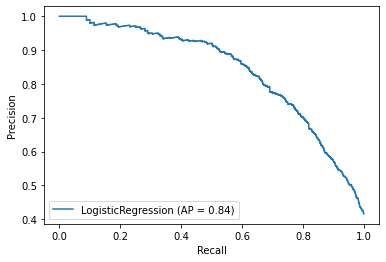

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

# plot precision-recall curve
y_pred_prob = review_classifier.predict_proba(x_test)
precision_recall_curve_values = precision_recall_curve(y_test, y_pred_prob[:,1])
plot_precision_recall_curve(estimator=review_classifier, X=x_test, y=y_test)

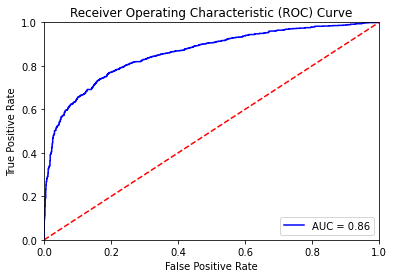

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# plot ROC
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision Tree Classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
dt_clf = DecisionTreeClassifier(random_state=0).fit(x_train, y_train)

In [21]:
y_pred = dt_clf.predict(x_test)

print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.64
Recall: 0.59
F1: 0.62
Average Precision: 0.55


### Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf_clf = RandomForestClassifier(n_jobs=2, random_state=0).fit(x_train, y_train)

In [25]:
y_pred = rf_clf.predict(x_test)

print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.89
Recall: 0.58
F1: 0.7
Average Precision: 0.69


### MLP Neural Net Classifier

In [26]:
from sklearn.neural_network import MLPClassifier

In [27]:
mlp_clf = MLPClassifier(random_state=0, max_iter=300).fit(x_train, y_train)

In [28]:
y_pred = mlp_clf.predict(x_test)

print("Precision:", round(precision_score(y_test, y_pred, average='binary'),2))
print("Recall:", round(recall_score(y_test, y_pred, average='binary'),2))
print("F1:", round(f1_score(y_test, y_pred, average='binary'),2))
print("Average Precision:", round(average_precision_score(y_test, y_pred),2))

Precision: 0.75
Recall: 0.7
F1: 0.72
Average Precision: 0.65
